This notebook how we transform the keras version of ANN-dropout into a pytorch version for the offline evaluation

In [2]:

import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Dropout
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

In [3]:
# define some hyperparameter of ANN_dropout based on ANN_1 with dropout layer in keras 
original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 


input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 405

batch_size = 3551



input_lay=Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation='elu')(input_lay)
x_1 =Dense(intermediate_dim, activation='elu')(x_0)
x_2 =Dense(intermediate_dim, activation='elu')(x_1)
x_3 =Dense(intermediate_dim, activation='elu')(x_2)
dr_out=Dropout(0.01,input_shape=(intermediate_dim,))(x_3) #dropout layer with dropout 0.01
outputs_1= Dense(original_dim_output,activation='elu')(dr_out)
outputs_A = Dense(original_dim_output,activation='linear')(outputs_1)
    
    # instantiate encoder model
ANN_1= Model(input_lay, outputs_A, name='ANN')
ANN_1.summary()

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 dense (Dense)               (None, 405)               44550     
                                                                 
 dense_1 (Dense)             (None, 405)               164430    
                                                                 
 dense_2 (Dense)             (None, 405)               164430    
                                                                 
 dense_3 (Dense)             (None, 405)               164430    
                                                                 
 dropout (Dropout)           (None, 405)               0         
                                                                 
 dense_4 (Dense)             (None, 112)               45472   

2023-07-04 08:44:00.262051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#load keras model weights and biases 
ANN_1.load_weights('real_geography/ANNs/ANNs_lin/ANN_1/ANN_1_CRM_lin_dro_0_01_model.h5')
ANN_1.summary()
ANN_1_weights=ANN_1.get_weights()

batch_size= 3551


Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 dense (Dense)               (None, 405)               44550     
                                                                 
 dense_1 (Dense)             (None, 405)               164430    
                                                                 
 dense_2 (Dense)             (None, 405)               164430    
                                                                 
 dense_3 (Dense)             (None, 405)               164430    
                                                                 
 dropout (Dropout)           (None, 405)               0         
                                                                 
 dense_4 (Dense)             (None, 112)               45472   

In [ ]:
# import pytorch

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# construct ANN-dropout in pytorch
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.X_1=nn.Linear(109,405)
        self.X_2=nn.Linear(405,405)
        self.X_3=nn.Linear(405,405)
        self.X_4=nn.Linear(405,405)
        self.X_5=nn.Dropout(p=0.01) #dropout layer with dr = 0.01
        self.X_6=nn.Linear(405,112)
        self.X_7=nn.Linear(112,112)
    def forward(self,x):
        x=F.elu_(self.X_1(x))
        x=F.elu_(self.X_2(x))
        x=F.elu_(self.X_3(x))
        x=F.elu_(self.X_4(x))
        x=self.X_5(x)
        x=F.elu_(self.X_6(x))
        x=self.X_7(x)
       
        
        return x
    
    
        



        


In [7]:
# build ANN_dropout
ANN_1_torch=ANN()
print(ANN_1_torch)

ANN(
  (X_1): Linear(in_features=109, out_features=405, bias=True)
  (X_2): Linear(in_features=405, out_features=405, bias=True)
  (X_3): Linear(in_features=405, out_features=405, bias=True)
  (X_4): Linear(in_features=405, out_features=405, bias=True)
  (X_5): Dropout(p=0.01, inplace=False)
  (X_6): Linear(in_features=405, out_features=112, bias=True)
  (X_7): Linear(in_features=112, out_features=112, bias=True)
)


In [8]:



print(ANN_1_torch.X_6.weight.shape)
#print(ANN_1_torch.X_8.bias.shape)


torch.Size([112, 405])


In [9]:
ANN_1_weights[10].shape


(112, 112)

In [10]:
ANN_1_weights[11].shape


(112,)

In [11]:
# load ANN_dropout keras weights and biases into pytorch model
ANN_1_torch.X_1.weight.data=to.from_numpy(np.transpose(ANN_1_weights[0]))
ANN_1_torch.X_1.bias.data=to.from_numpy(np.transpose(ANN_1_weights[1]))
ANN_1_torch.X_2.weight.data=to.from_numpy(np.transpose(ANN_1_weights[2]))
ANN_1_torch.X_2.bias.data=to.from_numpy(np.transpose(ANN_1_weights[3]))
ANN_1_torch.X_3.weight.data=to.from_numpy(np.transpose(ANN_1_weights[4]))
ANN_1_torch.X_3.bias.data=to.from_numpy(np.transpose(ANN_1_weights[5]))
ANN_1_torch.X_4.weight.data=to.from_numpy(np.transpose(ANN_1_weights[6]))
ANN_1_torch.X_4.bias.data=to.from_numpy(np.transpose(ANN_1_weights[7]))

ANN_1_torch.X_6.weight.data=to.from_numpy(np.transpose(ANN_1_weights[8]))
ANN_1_torch.X_6.bias.data=to.from_numpy(np.transpose(ANN_1_weights[9]))
ANN_1_torch.X_7.weight.data=to.from_numpy(np.transpose(ANN_1_weights[10]))
ANN_1_torch.X_7.bias.data=to.from_numpy(np.transpose(ANN_1_weights[11]))


In [12]:
# define input and output variables
in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values
NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the ANN dropout training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}




# construct vertical axis in pressure coords 


from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [13]:
# to save input and output normalization files
from cbrain.save_weights import save_norm

In [6]:
#save_norm(val_gen_II.input_transform,val_gen_II.output_transform,'real_geography/norm_files/')

In [14]:
#predict with keras
pred_keras= ANN_1.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 921us/step


In [15]:
print(pred_keras.shape)
pred_keras

(13824, 112)


array([[-4.9127266e-08,  8.5681677e-08, -4.3539330e-08, ...,
         5.9516144e-01,  1.7891512e+00,  9.9677432e-01],
       [-4.9592927e-08,  8.6612999e-08, -4.4237822e-08, ...,
         5.9531760e-01,  1.7890072e+00,  9.9664330e-01],
       [-4.9592927e-08,  8.6612999e-08, -4.4237822e-08, ...,
         5.9531152e-01,  1.7890118e+00,  9.9664545e-01],
       ...,
       [ 1.8626451e-09, -4.6566129e-09,  1.3969839e-09, ...,
         1.2931049e-02, -6.9833510e-03, -2.9324293e-03],
       [ 2.0954758e-09, -4.1909516e-09,  2.7939677e-09, ...,
         1.2932405e-02, -6.9829561e-03, -2.9315352e-03],
       [ 1.3969839e-09, -3.2596290e-09,  2.3283064e-09, ...,
         1.2908161e-02, -6.9837607e-03, -2.9588342e-03]], dtype=float32)

In [16]:
#predict with torch
pred_pytorch=ANN_1_torch(to.from_numpy(val_gen_II[300][0]))

In [17]:
pred_pytorch[0]

tensor([-3.3760e-08,  5.8208e-08, -2.9337e-08, -2.9569e-08, -1.6042e-07,
        -6.5786e-07, -1.1912e-06, -7.0408e-07, -5.3633e-06, -5.9081e-06,
        -2.0424e-05, -1.0033e-04, -2.3650e-04, -2.6893e-04, -2.8685e-07,
         6.1848e-04,  9.5426e-04,  2.4145e-04, -5.0977e-04, -1.1819e-03,
        -3.9539e-03, -1.7471e-03, -4.1103e-04, -7.6414e-04,  2.4297e-03,
        -5.3775e-04,  2.3149e-02, -1.2133e-02, -1.4006e-02, -4.9969e-03,
         8.3404e-04,  3.0274e-03,  4.2354e-03,  6.3531e-04,  4.9473e-03,
         2.5599e-03,  6.9456e-04, -1.9264e-03, -3.7705e-03, -3.6345e-03,
        -7.2529e-03, -1.1852e-02, -1.6644e-02, -2.1587e-02, -2.2744e-02,
        -1.9639e-02, -1.3081e-02, -1.6591e-02, -3.0997e-02, -2.7875e-02,
        -3.6572e-02, -3.3309e-03, -1.5018e-08, -9.1270e-08, -1.2107e-08,
        -5.9139e-08, -1.3970e-08, -5.2387e-10,  1.3097e-08, -6.7987e-08,
        -4.7265e-08,  6.2864e-08, -3.2131e-08, -2.2119e-08,  3.1287e-09,
        -1.5600e-08, -1.7091e-06, -4.3695e-04,  3.8

In [18]:
#get weights and biases 
module = to.jit.trace(ANN_1_torch.forward, to.from_numpy(val_gen_II[300][0]))

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1102081 / 1548288 (71.2%)
Greatest absolute difference: 2.8962734937667847 at index (7874, 91) (up to 1e-05 allowed)
Greatest relative difference: inf at index (560, 86) (up to 1e-05 allowed)
  _check_trace(


In [19]:
# and the same to save the model
mod = to.jit.trace(ANN_1_torch, to.from_numpy(val_gen_II[300][0]))

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1101555 / 1548288 (71.1%)
Greatest absolute difference: 3.8325085639953613 at index (6198, 91) (up to 1e-05 allowed)
Greatest relative difference: inf at index (7631, 104) (up to 1e-05 allowed)
  _check_trace(


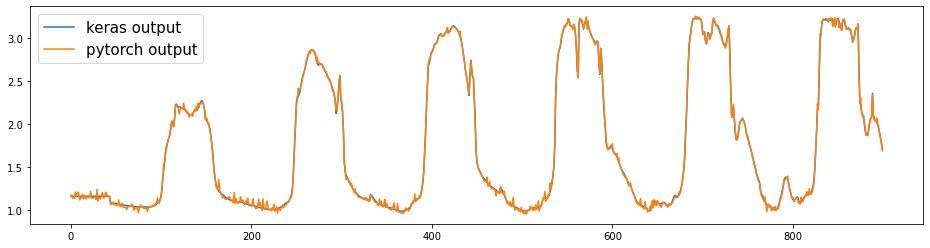

In [20]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

In [21]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=2E-6)

In [22]:
a.shape

(13824, 112)

In [23]:
np.where(a==False)[0].size

1127484

In [24]:
np.where(a==True)[0].size

420804

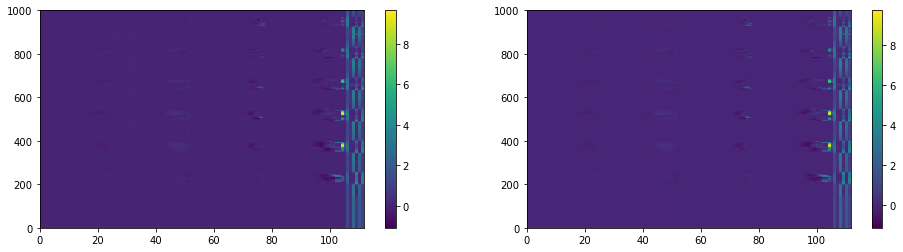

In [25]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])
plt.colorbar()

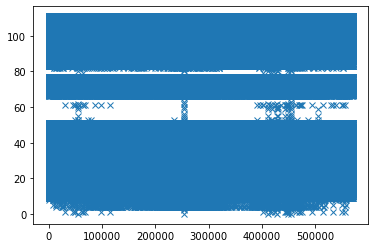

In [26]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-6)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [27]:
#save model + weights and biases 
to.save(ANN_1_torch,'real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch.pt')

In [28]:
# jit version that is used for offline analysis
to.jit.save(mod,'real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch_jit.pt')